In [1]:
git_repo = '../../..'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

In [2]:
# Load results from previous fit.
#filename = 'ryan_iris_bnp_full_data_fit_alpha8.0.json'
filename = 'ryan_simulation_bnp_full_data_fit_alpha8.0.json'
json_input_file = os.path.join(
    git_repo,
    'BNP_sensitivity/GMM_clustering/iris_fits/',
    filename)

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [3]:
moment_model = gmm_utils.InterestingMoments(model)
dg_deta = moment_model.get_moment_jacobian(best_param)
linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [4]:
moment_model.set_moments_from_free_par(best_param)
print(moment_model.moment_params)

Moment parameters:
	centroids:
[[-0.89862729 -0.6051695  -1.50125936  0.06510113 -1.40330541  0.61287858
   0.30745596  0.25663505  1.72137636  1.43666097  0.99828602 -0.29476781]
 [-0.61805749  0.66819207 -1.51109677 -0.9374954  -1.50996968 -0.10084349
   0.42731808  1.23903035  1.75667923  0.06332253  0.92203725 -0.42054208]]
	cluster_weights:
[0.07983739 0.05978831 0.13052355 0.03176939 0.13426964 0.08658021
 0.07998455 0.06383699 0.00479492 0.04485727 0.05730031 0.22645748]
	v_sticks:
[-2.45022684 -2.67426143 -1.72439711 -3.1046676  -1.43766809 -1.71158407
 -1.60762942 -1.6592461  -4.3277428  -1.85377782 -1.38057936]


In [5]:
import functional_sensitivity_lib as fun_sens_lib
stick_sens = fun_sens_lib.StickSensitivity(model, best_param, kl_hessian, dg_deta.T)

[-10.81935519]


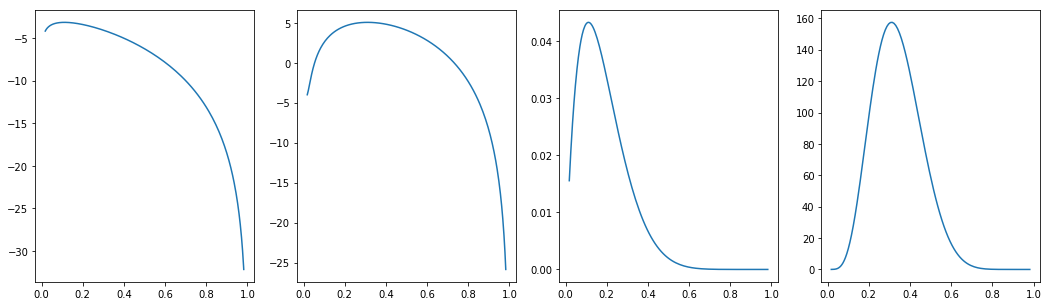

In [6]:

phi_center = 1
phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
print(phi_log_rescale)
def phi(logit_v):
    return(np.exp(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale))
logit_v_grid = np.linspace(-4, 4, 200)
v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(v_grid, stick_sens.get_log_p0_logit_stick(logit_v_grid))

plt.subplot(142)
plt.plot(v_grid, stick_sens.get_log_p0_logit_stick(logit_v_grid) + np.log(1 + phi(logit_v_grid)))

plt.subplot(143)
#plt.plot(v_grid, np.log(1 + phi(logit_v_grid)))
plt.plot(v_grid, np.exp(stick_sens.get_log_p0_logit_stick(logit_v_grid)))

plt.subplot(144)
plt.plot(v_grid, np.exp(stick_sens.get_log_p0_logit_stick(logit_v_grid) + np.log(1 + phi(logit_v_grid))))


In [7]:
# Choose the number of GH points.

import LinearResponseVariationalBayes.ExponentialFamilies as ef
model.global_vb_params.set_free(best_param)
vb_params = deepcopy(model.vb_params)

perturbed_log_density = lambda x : np.log(1.0 + phi(x))

expected_perturbations_list = []
gh_deg_list = np.arange(3, 100, 1)
for gh_deg in gh_deg_list:
    gmm_utils.set_gauss_hermite_points(vb_params, gh_deg=gh_deg)
    expected_perturbations_list.append(
        gmm_utils.get_e_log_perturbation_vec(vb_params, phi))

expected_perturbations_list = np.array(expected_perturbations_list)
#print(expected_perturbations_list.shape)
diffs = (expected_perturbations_list[1:, :] - \
         expected_perturbations_list[:-1, :]) / \
        np.abs(expected_perturbations_list[1:, :] + 1e-6)
#print(np.max(diffs, axis=1))
max_diffs = np.max(np.abs(diffs), axis=1) 
gh_deg_threshold = np.argmax(max_diffs < 1e-5)
gh_deg = max(10, gh_deg_threshold)
print(gh_deg, gh_deg_threshold, len(max_diffs))

10 9 96


In [8]:
# Check the gradients.

class PriorCheck(object):
    def __init__(self, model, phi):
        self.model = model
        self.global_vb_params = model.global_vb_params
        self.obj = obj_lib.Objective(
            self.global_vb_params, self.get_e_log_prior)
        self.phi = phi
    
    def get_e_log_prior(self):
        return np.sum(gmm_utils.get_e_log_perturbation_vec(
            self.model.vb_params, self.phi))

prior_check = PriorCheck(model, phi)
prior_check.obj.fun_free(best_param)
print('Should be non-zero: ', np.linalg.norm(prior_check.obj.fun_free_grad(best_param)))


Should be non-zero:  9.31930095570812


In [15]:
# Check the model prior.

def get_e_log_prior():
    return np.squeeze(
        gmm_utils.get_e_log_prior(
            model.vb_params, model.prior_params, phi=model.phi))

prior_obj = obj_lib.Objective(model.global_vb_params, get_e_log_prior)

model.phi = None
#g1 = prior_obj.fun_free_grad(best_param)
g1 = model.objective.fun_free_grad(best_param)

model.phi = phi
#g2 = prior_obj.fun_free_grad(best_param)
g2 = model.objective.fun_free_grad(best_param)

print('Should be nonzero:', np.linalg.norm(g1 - g2))

Should be nonzero: 9.31930095570812


In [10]:
model_refit = deepcopy(model)
gmm_utils.set_gauss_hermite_points(model_refit.vb_params, gh_deg=gh_deg)

In [17]:
# First fit with no perturbation but the increased number of gh points.
model_refit.phi = None
best_param_0, kl_hessian, kl_hessian_corrected, \
init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
model_refit.optimize_full(
    best_param,
    init_max_iter=100,
    final_max_iter=500)

print('Done. ')

BGFS
Iter: 0	 RMSE: 11.859820226630768	 Objective: 424.47954624941985
Iter: 10	 RMSE: 11.859819997944802	 Objective: 424.4795462494229
Iter: 20	 RMSE: 11.859820226630735	 Objective: 424.47954624941985
Iter: 30	 RMSE: 11.859820226630728	 Objective: 424.4795462494196
Iter: 40	 RMSE: 11.859820226630728	 Objective: 424.4795462494193
Iter: 50	 RMSE: 11.859820226630728	 Objective: 424.4795462494193
Iter: 60	 RMSE: 11.859820226630728	 Objective: 424.4795462494193
Iter: 70	 RMSE: 11.859820226630728	 Objective: 424.4795462494193
Iter: 80	 RMSE: 11.859820226630728	 Objective: 424.4795462494204
Iter: 90	 RMSE: 11.859820226630728	 Objective: 424.4795462494193
Iter: 100	 RMSE: 11.859725027520234	 Objective: 424.4795467108787
         Current function value: 424.479546
         Iterations: 0
         Function evaluations: 103
         Gradient evaluations: 91
Conditioned Newton:
i =  0
Iter: 110	 RMSE: 11.859770054568902	 Objective: 424.47954627382467
Iter: 120	 RMSE: 11.859820226582917	 Objective: 

In [16]:
# Then fit with the perturbation.
log_epsilon = np.log(1e-3)
def phi_eps(x):
    return np.exp(np.log(phi(x)) + log_epsilon)

model_refit.phi = phi_eps
best_param_phi, kl_hessian_phi, kl_hessian_corrected_phi, \
init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
model_refit.optimize_full(
    best_param,
    init_max_iter=100,
    final_max_iter=500)

print('Done. ')

BGFS
Iter: 0	 RMSE: 11.859820226630768	 Objective: 417.46354078457114
Iter: 10	 RMSE: 11.702025196734777	 Objective: 416.1216052051893
Iter: 20	 RMSE: 11.827570044213083	 Objective: 415.26971462467
Iter: 30	 RMSE: 11.912487308049963	 Objective: 414.6925751554709
Iter: 40	 RMSE: 11.961289366318443	 Objective: 414.6122107623088
Iter: 50	 RMSE: 11.955604695411944	 Objective: 414.5874910163459
Iter: 60	 RMSE: 11.96818224821465	 Objective: 414.579192806253
Iter: 70	 RMSE: 11.98230612162928	 Objective: 414.57410403486574
Iter: 80	 RMSE: 12.028486587010622	 Objective: 414.5377939084077
Iter: 90	 RMSE: 12.061457862451128	 Objective: 414.5090951226365
Iter: 100	 RMSE: 12.061456527422482	 Objective: 414.5090945747073
Iter: 110	 RMSE: 12.061456527420988	 Objective: 414.5090945747056
Iter: 120	 RMSE: 12.06145652742099	 Objective: 414.5090945747056
Iter: 130	 RMSE: 12.06145652742099	 Objective: 414.5090945747056
Iter: 140	 RMSE: 12.06145652742099	 Objective: 414.5090945747056
Iter: 150	 RMSE: 12.06

In [18]:
print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

This is nonzero if phi did anything: 2.7729519895533286


In [19]:
stick_sens = fun_sens_lib.StickSensitivity(model, best_param, kl_hessian, dg_deta.T)